# Analyze geolocation
To do:
- Analyze variance per device_id -> select location where most often found

In [191]:
import os
import math

import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline

dir_in = './data_ori/'
dir_out = './data/'

In [155]:
events = pd.read_csv(dir_in + 'events.csv')

# From http://www.tageo.com/index-e-ch-cities-CN.htm
gps_cities = {}
gps_cities['beijing'] = (39.93, 116.4) #
gps_cities['wuhan'] = (30.58, 114.27) #
gps_cities['chengdu'] = (30.670, 104.07)#
gps_cities['tianjin'] = (39.130, 117.20)#
gps_cities['shenyang'] = (41.800, 123.450)#
gps_cities['xian'] = (34.270, 108.900) #
gps_cities['guangzhou'] = (23.120, 113.250) # Canton
gps_cities['harbin'] = (45.750, 126.650)
gps_cities['chongqing'] = (29.57, 106.58) #
gps_cities['hongkong'] = (22.20, 114.10) #
gps_cities['nanjing'] = (32.050, 118.78)
gps_cities['shanghai'] = (31.230, 121.470) #

In [156]:
dist_cols = ['dist_' + k for k in gps_cities.keys()]
close_to_cols = ['close_to_' + k for k in gps_cities.keys()]
print close_to_cols

['close_to_beijing', 'close_to_guangzhou', 'close_to_chengdu', 'close_to_tianjin', 'close_to_hongkong', 'close_to_shenyang', 'close_to_xian', 'close_to_nanjing', 'close_to_wuhan', 'close_to_shanghai', 'close_to_harbin', 'close_to_chongqing']


### Calculate per device home and relative number of events at home
Home is calculated by the most common longitude coordinate
Work is estimated by the second most common longitude coordinate

In [157]:
events_no0 = events[(events.longitude>0) & (events.latitude>0)].round(1)
print events_no0.shape
events_no0.groupby(['device_id'])['longitude'].value_counts().head()

(2282649, 5)


device_id             longitude
-9222956879900151005  113.2         52
-9221825537663503111  113.5         50
                      113.4         43
                      113.8          5
-9221026417907250887  114.4        132
dtype: int64

In [158]:
n_locations = events_no0.groupby(['device_id'])['longitude'].nunique().reset_index()
print n_locations.shape
n_locations.head()

(30674, 2)


,device_id,longitude
0,-9222956879900151005,1
1,-9221825537663503111,3
2,-9221026417907250887,1
3,-9220452176650064280,1
4,-9220061629197656378,2


In [159]:
home=events_no0.groupby(['device_id'])['longitude'].value_counts().reset_index().groupby(['device_id']).first()
print home.shape
home.head()

(30674, 2)


,longitude,0
device_id,,
-9222956879900151005,113.2,52
-9221825537663503111,113.5,50
-9221026417907250887,114.4,132
-9220452176650064280,1.0,29
-9220061629197656378,124.9,32


In [160]:
n_events = events_no0.groupby(['device_id']).size()
n_events.head()

device_id
-9222956879900151005     52
-9221825537663503111     98
-9221026417907250887    132
-9220452176650064280     29
-9220061629197656378     39
dtype: int64

In [161]:
r_home = home[0].div(n_events, axis=0)
r_home.head()

device_id
-9222956879900151005    1.000000
-9221825537663503111    0.510204
-9221026417907250887    1.000000
-9220452176650064280    1.000000
-9220061629197656378    0.820513
dtype: float64

In [162]:
work=events_no0.groupby(['device_id'])['longitude'].value_counts().reset_index().groupby(['device_id']).nth(1)
print work.shape
work.head()

(11284, 2)


,0,longitude
device_id,,
-9221825537663503111,43,113.4
-9220061629197656378,7,124.8
-9220053820290758471,9,114.2
-9215722913042087294,96,121.4
-9213411371629884254,3,117.1


In [163]:
r_work = work[0].div(n_events, axis=0)
r_work.fillna(0, inplace=True)
r_work.head()

device_id
-9222956879900151005    0.000000
-9221825537663503111    0.438776
-9221026417907250887    0.000000
-9220452176650064280    0.000000
-9220061629197656378    0.179487
dtype: float64

In [164]:
events.set_index('device_id', inplace=True)

In [165]:
events['home'] = home['longitude']
events['r_home'] = r_home
events['work'] = work['longitude']
events['r_work'] = r_work

In [166]:
events.sample(10)

,event_id,timestamp,longitude,latitude,home,r_home,work,r_work
device_id,,,,,,,,
5098778421671837341,960958,2016-05-04 15:26:36,112.56,33.00,112.6,0.766415,112.5,0.233585
2924557770001720646,235695,2016-05-07 20:06:54,0.00,0.00,114.4,1.000000,NaN,0.000000
-5196196551075293756,1366802,2016-05-04 11:40:48,119.45,35.42,119.5,0.564870,119.4,0.369261
5544032646057692655,2016353,2016-05-04 07:34:58,0.00,0.00,113.2,0.952381,113.3,0.047619
-6216864668208339353,1641712,2016-05-07 09:09:29,112.71,34.64,112.7,1.000000,NaN,0.000000
4608843106719019589,1004698,2016-05-03 06:10:42,113.24,35.26,113.2,1.000000,NaN,0.000000
8442098452928962575,1070204,2016-05-06 17:15:28,113.64,22.96,113.6,1.000000,NaN,0.000000
-7250168333818636477,1624165,2016-05-05 22:07:35,106.31,38.51,106.3,0.880478,106.2,0.119522
-7146523025031567409,2646118,2016-05-01 10:51:16,0.00,0.00,116.3,0.994924,117.5,0.005076


### Select per device home coordinates

In [167]:
events_home = events[events.longitude.round(1)==events.home].reset_index().groupby('device_id').first()
events_work = events[events.longitude.round(1)==events.work].reset_index().groupby('device_id').first()

In [168]:
events_home.head(5)

,event_id,timestamp,longitude,latitude,home,r_home,work,r_work
device_id,,,,,,,,
-9222956879900151005,12679,2016-05-07 12:18:35,113.24,23.19,113.2,1.000000,NaN,0.000000
-9221825537663503111,84716,2016-05-01 08:50:11,113.48,34.92,113.5,0.510204,113.4,0.438776
-9221026417907250887,6402,2016-05-02 07:56:49,114.36,30.87,114.4,1.000000,NaN,0.000000
-9220452176650064280,105475,2016-05-06 08:19:24,1.00,1.00,1.0,1.000000,NaN,0.000000
-9220061629197656378,279922,2016-05-05 13:08:11,124.90,46.60,124.9,0.820513,124.8,0.179487


In [169]:
events_work.head(5)

,event_id,timestamp,longitude,latitude,home,r_home,work,r_work
device_id,,,,,,,,
-9221825537663503111,74539,2016-05-07 07:52:34,113.36,33.63,113.5,0.510204,113.4,0.438776
-9220061629197656378,363901,2016-05-05 14:41:15,124.85,46.65,124.9,0.820513,124.8,0.179487
-9220053820290758471,35244,2016-05-04 07:24:32,114.17,38.73,115.0,0.678571,114.2,0.321429
-9215722913042087294,2808,2016-05-05 04:30:09,121.39,31.22,121.5,0.541126,121.4,0.415584
-9213411371629884254,1153194,2016-05-06 16:30:16,117.11,36.70,117.3,0.727273,117.1,0.272727


In [170]:
### Calculate coordinates of home and work
device_geo_data = events.groupby(events.index).first()[['r_home', 'r_work']]
device_geo_data['lon_home'] = events_home['longitude']
device_geo_data['lat_home'] = events_home['latitude']
device_geo_data['lon_work'] = events_work['longitude']
device_geo_data['lat_work'] = events_work['latitude']

In [171]:
print device_geo_data.shape
device_geo_data.sample(5)

(60865, 6)


,r_home,r_work,lon_home,lat_home,lon_work,lat_work
device_id,,,,,,
-6757101425188533129,0.860759,0.139241,113.70,22.93,113.65,22.91
-4052199241818426587,1.000000,0.000000,118.62,25.03,NaN,NaN
7816447071566673220,NaN,NaN,NaN,NaN,NaN,NaN
-2823864655698018261,0.578947,0.263158,106.49,29.54,106.32,29.63
-4229204516857154485,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
distance_for_close = 1.1

for k in gps_cities.keys():
    v = gps_cities[k]
    device_geo_data['dist_' + k] = device_geo_data[['lon_home','lat_home']].apply(lambda x: math.sqrt( (x[0]-v[1])**2 + (x[1]-v[0])**2 ), axis=1)
    device_geo_data['close_to_' + k] = (device_geo_data['dist_' + k] < distance_for_close).astype(int)
### Calculate distance work
device_geo_data['dist_work'] = device_geo_data[['lon_home','lat_home','lon_work','lat_work']] \
.apply(lambda x: math.sqrt( (x[0]-x[2])**2 + (x[1]-x[3])**2 ), axis=1).clip(upper=100)
device_geo_data.fillna(0, inplace=True)

In [185]:
device_geo_data.sample(5)

,r_home,r_work,lon_home,lat_home,lon_work,lat_work,dist_beijing,close_to_beijing,dist_guangzhou,close_to_guangzhou,...,close_to_nanjing,dist_wuhan,close_to_wuhan,dist_shanghai,close_to_shanghai,dist_harbin,close_to_harbin,dist_chongqing,close_to_chongqing,dist_work
device_id,,,,,,,,,,,,,,,,,,,,,
-7675625530297431005,0.000000,0.000000,0.00,0.00,0.00,0.00,123.058380,0,115.585885,0,...,0,118.291036,0,125.420388,0,134.659886,0,110.605973,0,0.000000
-6637129786124410927,0.960000,0.040000,121.27,31.24,121.41,31.19,9.961576,0,11.412923,0,...,0,7.031045,0,0.200250,1,15.475287,0,14.784620,0,0.148661
-6010510942036698058,0.978395,0.021605,116.38,39.87,116.55,40.07,0.063246,1,17.039935,0,...,0,9.526605,0,10.027846,0,11.834158,0,14.217243,0,0.262488
-6890136880318416483,0.802395,0.191617,103.96,31.00,103.90,31.07,15.313344,0,12.181892,0,...,0,10.318551,0,17.511511,0,27.062864,0,2.984845,0,0.092195
-5242428010327336856,0.828571,0.171429,114.02,22.63,114.43,23.12,17.462944,0,0.912688,1,...,0,7.953930,0,11.378159,0,26.344853,0,10.174340,0,0.638905


### Validation

In [186]:
# How many devices:
device_geo_data.shape

(60865, 31)

In [187]:
device_geo_data[close_to_cols].sum(axis=0)

close_to_beijing      1813
close_to_guangzhou    3079
close_to_chengdu      1373
close_to_tianjin      1116
close_to_hongkong     2241
close_to_shenyang      490
close_to_xian          443
close_to_nanjing       815
close_to_wuhan         802
close_to_shanghai     1858
close_to_harbin        194
close_to_chongqing     503
dtype: int64

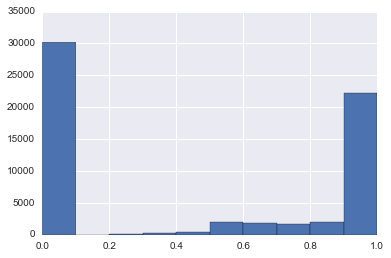

In [188]:
device_geo_data['r_home'].hist()

(0, 50)

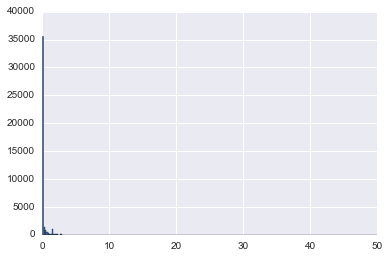

In [189]:
device_geo_data['dist_work'].hist(bins=500)
plt.xlim([0,50])

In [195]:
# Check whether devices are close to multiple cities
# For distance_for_close = 1.0: 1788 devices double, 11654 are close to cities
# For distance_for_close = 1.1: 2634 devices double, 12039 are close to cities <- most reasonable
# For distance_for_close = 1.3: 4569 devices double, 12832 are close to cities
# For distance_for_close = 1.5: 5250 devices double, 13788 are close to cities
# For distance_for_close = 2.0: 6725 devices double, 15892 are close to cities


### Save features files

In [194]:
feature_file = 'features_geo.csv'
device_geo_data.to_csv(dir_out + feature_file)